# Optimization of an X-Gate for a Transmon Qubit

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
%watermark -v --iversions

qutip       4.3.1
numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.2
matplotlib.pylab  1.15.4
krotov      0.0.1
CPython 3.6.7
IPython 7.1.1


## Define the Hamiltonian

In [2]:
def transmon_ham_and_states(Ec=0.386, EjEc=45, nstates=8, ng=0.0, T=10.0, steps=1000):
    """Transmon Hamiltonian"""
    Ej = EjEc * Ec
    n = np.arange(-nstates, nstates+1)
    up = np.diag(np.ones(2*nstates),k=-1)
    do = up.T
    H0 = qutip.Qobj(np.diag(4*Ec*(n - ng)**2) - Ej*(up+do)/2.0)
    H1 = qutip.Qobj(-2*np.diag(n))
    
    eigenvals, eigenvecs = scipy.linalg.eig(H0.full())
    ndx = np.argsort(eigenvals.real)
    E = eigenvals[ndx].real
    V = eigenvecs[:,ndx]
    w01 = E[1]-E[0] # Transition energy between states
    
    psi0 = qutip.Qobj(V[:, 0])
    psi1 = qutip.Qobj(V[:, 1])    
    
    profile = lambda t: np.exp(-40.0*(t/T - 0.5)**2)
    eps0 = lambda t, args: 0.5 * profile(t) * np.cos(8*np.pi*w01*t)
    return ([H0, [H1, eps0]], psi0, psi1)

In [3]:
H, psi0, psi1 = transmon_ham_and_states()

In [4]:
proj0 = psi0 * psi0.dag()
proj1 = psi1 * psi1.dag()

## Optimization target

In [5]:
tlist = np.linspace(0, 10, 1000)

In [6]:
objectives = [
    krotov.Objective(initial_state=psi0, target_state=psi1, H=H),
    krotov.Objective(initial_state=psi1, target_state=psi0, H=H)
]

In [7]:
def S(t):
    """Shape function for the pulse update"""
    dt = tlist[1] - tlist[0]
    steps = len(tlist)
    return np.exp(-40.0*(t/((steps-1)*dt)-0.5)**2)

pulse_options = {
    H[1][1]: krotov.PulseOptions(lambda_a=1, shape=S)
}

def print_fidelity(**args): 
    F_re = np.average(np.array(args['tau_vals']).real)
    print("Iteration %d: \tF = %f" % (args['iteration'], F_re))
    return F_re

## Simulate dynamics of the guess pulse

In [8]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

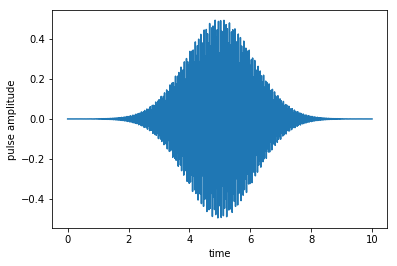

In [9]:
plot_pulse(H[1][1], tlist)

In [10]:
guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0, proj1])
# using initial state psi0 = objectives[0].initial_state

In [11]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

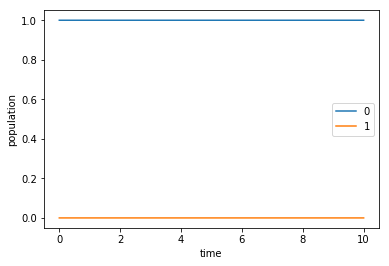

In [12]:
plot_population(guess_dynamics)

## Optimize

In [13]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [14]:
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity, iter_stop=3)

INFO:krotov:Initializing optimization with Krotov's method
INFO:krotov:Started initial forward propagation of objective 0
INFO:krotov:Finished initial forward propagation of objective 0
INFO:krotov:Started initial forward propagation of objective 1
INFO:krotov:Finished initial forward propagation of objective 1
INFO:krotov:Started Krotov iteration 1
INFO:krotov:Started backward propagation of state 0


Iteration 0: 	F = -0.000000


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started backward propagation of state 1
INFO:krotov:Finished backward propagation of state 1
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 1
INFO:krotov:Started Krotov iteration 2
INFO:krotov:Started backward propagation of state 0


Iteration 1: 	F = 0.107476


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started backward propagation of state 1
INFO:krotov:Finished backward propagation of state 1
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 2
INFO:krotov:Started Krotov iteration 3
INFO:krotov:Started backward propagation of state 0


Iteration 2: 	F = 0.410732


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started backward propagation of state 1
INFO:krotov:Finished backward propagation of state 1
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 3


Iteration 3: 	F = 0.694586


In [15]:
oct_result

Krotov Optimization Result
--------------------------
- Started at 2018-11-18 01:07:49
- Number of objectives: 2
- Number of iterations: 3
- Ended at 2018-11-18 01:08:11

In [16]:
["%.2e" % F for F in oct_result.info_vals]

['-8.64e-09', '1.07e-01', '4.11e-01', '6.95e-01']

In [17]:
logger.setLevel(logging.WARN)

## Simulate dynamics of the optimized pulse

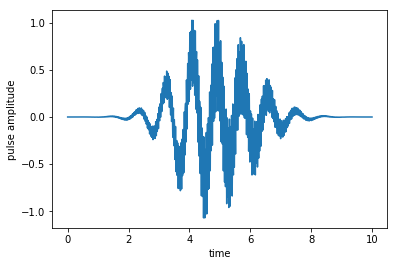

In [18]:
plot_pulse(oct_result.optimized_controls[0], tlist)

In [19]:
opt_dynamics = oct_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj0, proj1])
# using initial state psi0 = oct_result.optimized_objectives[0].initial_state

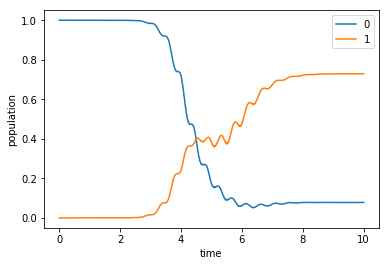

In [20]:
plot_population(opt_dynamics)

We may also propagate the optimization result using the same propagator that was
used in the optimization (instead of `qutip.mesolve`). The main difference
between the two propagations is that `mesolve` assumes piecewise constant pulses
that switch between two points in `tlist`, whereas `propagate` assumes that
pulses are constant on the intervals of `tlist`, and thus switches *on* the
points in `tlist`.

In [21]:
opt_dynamics2 = oct_result.optimized_objectives[0].propagate(
    tlist, e_ops=[proj0, proj1], propagator=krotov.propagators.expm)

The difference between the two propagations gives an indication of the "time
discretization error". If this error were unacceptably large, we would need a
smaller time step.

In [22]:
"%.2e" % abs(opt_dynamics2.expect[0][-1] - opt_dynamics.expect[0][-1])

'6.54e-05'